In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [2]:
candidates = pd.read_excel(r"C:\Users\abhin\LLM and ML\GNN\DATASET\candidates.xlsx")
jobs = pd.read_excel(r"C:\Users\abhin\LLM and ML\GNN\DATASET\jobs.xlsx")

In [3]:
def encode_skills(skills):
    skills_list = [list(map(int, str(skill).split(','))) for skill in skills]
    mlb = MultiLabelBinarizer()
    one_hot_encoded = mlb.fit_transform(skills_list)
    return one_hot_encoded , mlb




In [4]:
job_skills = list(jobs["SKILLS_REQ"])
can_skills  = list(candidates["SKILLS"])

In [5]:
can_skills

[0, '0,1,2,3', '0,1', '0,2,3', '0,1,3', '0,1,2', 1, 3]

In [6]:
job_encoded ,mlb_j =encode_skills(job_skills)
can_encoded,mlb_j=encode_skills(can_skills)

In [7]:
for i in range(len(job_encoded)):
    jobs.at[i,"SKILLS_REQ"]= job_encoded[i]
for i in range(len(can_encoded)):
    candidates.at[i,"SKILLS"]= can_encoded[i]

In [8]:
jobs

,EXP_REQ,TYPE,SKILLS_REQ
0,0,1,"[1, 0, 0, 0]"
1,2,0,"[0, 1, 1, 0]"
2,4,0,"[0, 1, 1, 1]"
3,1,1,"[0, 1, 1, 0]"
4,1,1,"[0, 0, 0, 1]"
5,0,1,"[1, 0, 0, 0]"
6,3,0,"[0, 0, 1, 1]"
7,2,0,"[1, 0, 1, 1]"
8,0,1,"[1, 1, 0, 0]"
9,2,0,"[1, 0, 1, 1]"


In [9]:
def df_to_tensor_job(df):
    exp_tensor = torch.tensor(df["EXP_REQ"].values, dtype=torch.float32).unsqueeze(1) 
    skills_tensor = torch.tensor(df["SKILLS_REQ"].tolist(), dtype=torch.float32)
    
    final_tensor =  torch.cat([exp_tensor, skills_tensor], dim=1)
    
    return final_tensor

def df_to_tensor_can(df):
    exp_tensor = torch.tensor(df["JOB_EXP"].values, dtype=torch.float32).unsqueeze(1)
    skills_tensor = torch.tensor(df["SKILLS"].tolist(), dtype=torch.float32)
    
    final_tensor = torch.cat([exp_tensor, skills_tensor], dim=1)
    
    return final_tensor
    

In [10]:
job_tensors= df_to_tensor_job(jobs)
can_tensors= df_to_tensor_can(candidates)

C:\Users\abhin\AppData\Local\Temp\ipykernel_21916\3606829091.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  skills_tensor = torch.tensor(df["SKILLS_REQ"].tolist(), dtype=torch.float32)


In [11]:
node_features=torch.cat([can_tensors, job_tensors], dim=0)

In [12]:
node_features.shape

torch.Size([18, 5])

In [13]:
def create_edge_index_and_attr(candidates, jobs):
    edge_index = []
    edge_attr = []
    
    for c in range(len(candidates)):
        for j in range(len(jobs)):
            if candidates['JOB_EXP'][c] <= jobs['EXP_REQ'][j]:  
                
                job_skills = jobs['SKILLS_REQ'][j]
                candidate_skills = candidates['SKILLS'][c]
        
                matching_skills = sum(a * b for a, b in zip(job_skills, candidate_skills))
                total_skills = sum(job_skills) 
                
                weight = matching_skills / total_skills if total_skills > 0 else 0
                
                edge_index.append([c, len(candidates) + j]) 
                edge_attr.append([weight]) 
    
   
    edge_index = torch.tensor(edge_index, dtype=torch.long).T  
    edge_attr = torch.tensor(edge_attr, dtype=torch.float32)  

    return edge_index, edge_attr

edge_index, edge_attr = create_edge_index_and_attr(candidates, jobs)

print("Edge Index Shape:", edge_index.shape)  
print("Edge Attribute Shape:", edge_attr.shape) 


Edge Index Shape: torch.Size([2, 58])
Edge Attribute Shape: torch.Size([58, 1])


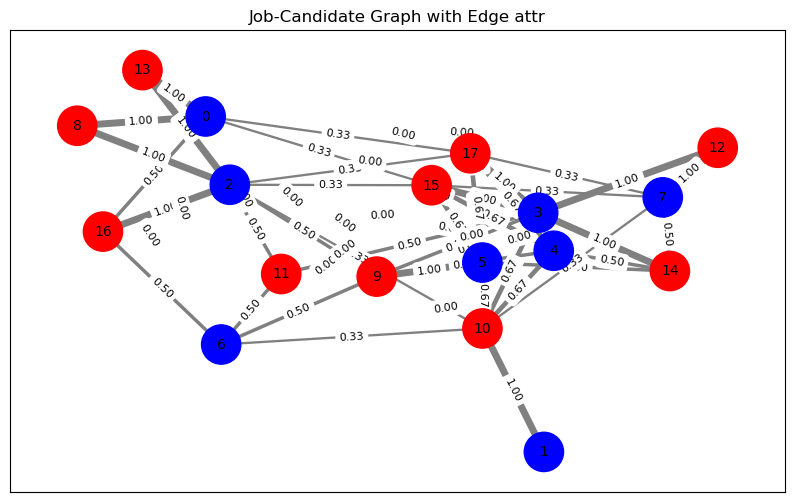

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()


num_jobs = len(jobs) 
num_candidates = len(candidates)  


for i in range(num_candidates):
    G.add_node(i, color='blue', label=f"Candidate{i}")

for i in range(num_candidates, num_jobs + num_candidates):
    G.add_node(i, color='red', label=f"Job {i-num_candidates}")


edges = list(zip(edge_index[0].tolist(), edge_index[1].tolist()))
for i, (u, v) in enumerate(edges):
    G.add_edge(u, v, weight=edge_attr[i].item())



node_colors = [G.nodes[n]['color'] for n in G.nodes]


edge_labels = {(u, v): f"{w:.2f}" for u, v, w in G.edges(data="weight")}
edge_widths = [w[0] * 5 for w in edge_attr.tolist()]  


plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", 
        node_size=800, font_size=10, width=edge_widths)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Job-Candidate Graph with Edge attr")
plt.show()


In [15]:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [17]:
print(data.x)

tensor([[0., 1., 0., 0., 0.],
        [4., 1., 1., 1., 1.],
        [0., 1., 1., 0., 0.],
        [1., 1., 0., 1., 1.],
        [2., 1., 1., 0., 1.],
        [2., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [2., 0., 1., 1., 0.],
        [4., 0., 1., 1., 1.],
        [1., 0., 1., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [3., 0., 0., 1., 1.],
        [2., 1., 0., 1., 1.],
        [0., 1., 1., 0., 0.],
        [2., 1., 0., 1., 1.]])


In [18]:
class JobGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(JobGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [19]:
model = JobGCN(in_channels=5,hidden_channels=9,out_channels=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

In [20]:
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.x) 
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 1.3450273275375366
Epoch 10, Loss: 0.41867968440055847
Epoch 20, Loss: 0.3131111264228821
Epoch 30, Loss: 0.24683333933353424
Epoch 40, Loss: 0.20321711897850037
Epoch 50, Loss: 0.18083281815052032
Epoch 60, Loss: 0.16454283893108368
Epoch 70, Loss: 0.15729942917823792
Epoch 80, Loss: 0.15264607965946198
Epoch 90, Loss: 0.14857037365436554


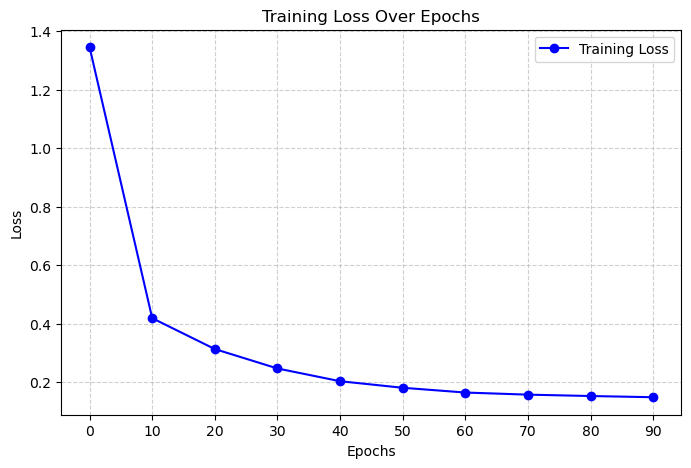

In [23]:
import matplotlib.pyplot as plt

# Epochs and corresponding loss values
epochs = list(range(0, 100, 10))
loss_values = [
    1.3450, 0.4187, 0.3131, 0.2468, 0.2032, 
    0.1808, 0.1645, 0.1573, 0.1526, 0.1485
]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label="Training Loss")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.xticks(epochs)  # Show only recorded epochs
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# Show the plot
plt.show()


In [24]:
exp = int(input("Enter JOB EXP :"))
skills=input("Enter Skills C - 0 , C++ - 1 , Java -2 , Python - 3 (in case of multiple skills enter as comma sperated) :")

Enter JOB EXP :2
Enter Skills C - 0 , C++ - 1 , Java -2 , Python - 3 (in case of multiple skills enter as comma sperated) :2


In [22]:
out

tensor([[-0.0784,  0.3608,  0.0738, -0.0447,  0.1484],
        [ 3.9472,  0.8422,  1.0851,  0.9416,  1.0902],
        [-0.2079,  0.6441,  0.4875, -0.1127, -0.0520],
        [ 1.3045,  0.3458,  0.1909,  0.9940,  1.1353],
        [ 2.3323,  0.4309,  0.4519,  0.4898,  0.5641],
        [ 1.8722,  0.4199,  0.3931,  0.4462,  0.5669],
        [ 0.0400,  0.5896,  0.4504, -0.0451,  0.0614],
        [ 0.5189,  0.3906,  0.2212,  0.2551,  0.5110],
        [ 0.0927,  0.6155,  0.4334,  0.0589,  0.0290],
        [ 2.3244,  0.5390,  0.5186,  0.8884,  0.7101],
        [ 3.6306,  0.6799,  0.8043,  1.2075,  0.9845],
        [ 0.8140,  0.5363,  0.3751,  0.5712,  0.5189],
        [ 0.8155,  0.5357,  0.3737,  0.5783,  0.5252],
        [ 0.0927,  0.6155,  0.4334,  0.0589,  0.0290],
        [ 2.3386,  0.5386,  0.5185,  0.9009,  0.7206],
        [ 2.3268,  0.5381,  0.5167,  0.9020,  0.7227],
        [ 0.0919,  0.6223,  0.4423,  0.0493,  0.0127],
        [ 2.3268,  0.5381,  0.5167,  0.9020,  0.7227]], grad_fn=<

In [25]:
def add_new_user(candidates,can_tensors,exp,skills,binarizer=None):
    exp1=[exp]
    listi = [list(map(int, str(skills).split(',')))]
    encoded = binarizer.transform(listi)
    encoded_flat = encoded.flatten()
    new_row = pd.DataFrame({'JOB_EXP': [exp], 'SKILLS': [encoded_flat.tolist()]})
    candidates=pd.concat([candidates,new_row],ignore_index=True)
    exp_tensor = torch.tensor(exp1, dtype=torch.float32).unsqueeze(1)
    skills_tensor = torch.tensor(encoded, dtype=torch.float32)
    final_tensor = torch.cat([exp_tensor, skills_tensor], dim=1)
    print(final_tensor.shape)
    final_tensor = torch.cat([can_tensors,final_tensor],dim=0)
    return final_tensor , candidates

In [26]:
mlb_j.classes_

array([0, 1, 2, 3])

In [27]:
can_tensors , candidates = add_new_user(candidates,can_tensors,exp,skills,mlb_j)
print(can_tensors.shape)

torch.Size([1, 5])
torch.Size([9, 5])


In [28]:
candidates

,JOB_EXP,SKILLS
0,0,"[1, 0, 0, 0]"
1,4,"[1, 1, 1, 1]"
2,0,"[1, 1, 0, 0]"
3,1,"[1, 0, 1, 1]"
4,2,"[1, 1, 0, 1]"
5,2,"[1, 1, 1, 0]"
6,0,"[0, 1, 0, 0]"
7,0,"[0, 0, 0, 1]"
8,2,"[0, 0, 1, 0]"


In [29]:
node_features = torch.cat([can_tensors,job_tensors],dim=0)

In [30]:
node_features.shape

torch.Size([19, 5])

In [31]:
edge_index, edge_attr = create_edge_index_and_attr(candidates, jobs)

In [32]:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

In [34]:
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out, data.x) 
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.09141288697719574
Epoch 10, Loss: 0.09078444540500641
Epoch 20, Loss: 0.09022079408168793
Epoch 30, Loss: 0.08972413092851639
Epoch 40, Loss: 0.08927761763334274
Epoch 50, Loss: 0.08886446803808212
Epoch 60, Loss: 0.08848647773265839
Epoch 70, Loss: 0.08814224600791931
Epoch 80, Loss: 0.08782617747783661
Epoch 90, Loss: 0.08753672242164612


In [35]:
model.eval()

JobGCN(
  (conv1): GCNConv(5, 9)
  (conv2): GCNConv(9, 5)
)

In [36]:
with torch.no_grad():
        embeddings = model(data.x,data.edge_index)
new_user_idx = len(candidates) - 1  
user_embedding = embeddings[new_user_idx].unsqueeze(0)
job_start_idx = len(candidates) 
job_embeddings = embeddings[job_start_idx:] 
similarity_scores = torch.nn.functional.cosine_similarity(user_embedding, job_embeddings)
top_k_indices = torch.argsort(similarity_scores, descending=True)[:3]
recommended_jobs = jobs.iloc[top_k_indices.cpu().numpy()]

In [37]:
print(recommended_jobs)

   EXP_REQ  TYPE    SKILLS_REQ
1        2     0  [0, 1, 1, 0]
6        3     0  [0, 0, 1, 1]
7        2     0  [1, 0, 1, 1]


In [38]:
jobs

,EXP_REQ,TYPE,SKILLS_REQ
0,0,1,"[1, 0, 0, 0]"
1,2,0,"[0, 1, 1, 0]"
2,4,0,"[0, 1, 1, 1]"
3,1,1,"[0, 1, 1, 0]"
4,1,1,"[0, 0, 0, 1]"
5,0,1,"[1, 0, 0, 0]"
6,3,0,"[0, 0, 1, 1]"
7,2,0,"[1, 0, 1, 1]"
8,0,1,"[1, 1, 0, 0]"
9,2,0,"[1, 0, 1, 1]"


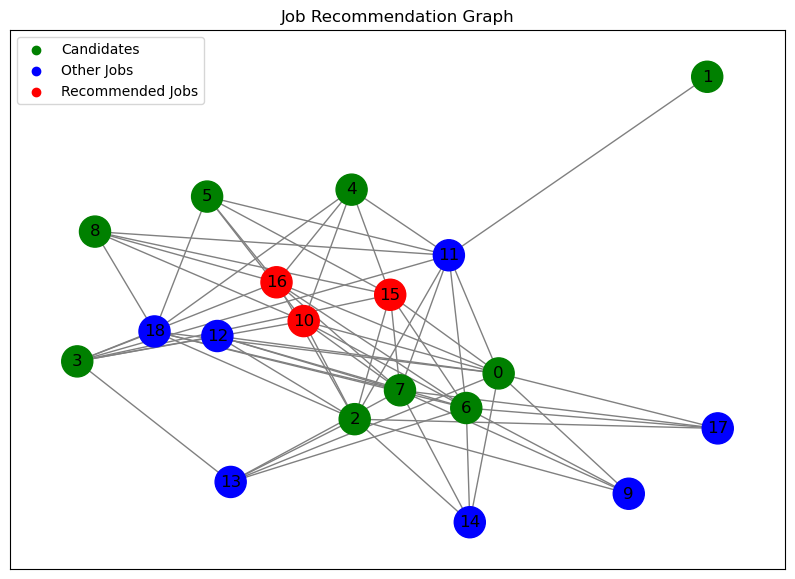

In [39]:
G = nx.Graph()
num_candidates = len(candidates)
num_jobs = len(jobs)

for i in range(num_candidates):
    G.add_node(i, type="candidate")
for j in range(num_jobs):
    G.add_node(num_candidates + j, type="job")

edge_list = data.edge_index.T.cpu().numpy().tolist() 
G.add_edges_from(edge_list)

color_map = []
job_indices = jobs.index.tolist()  
recommended_indices = recommended_jobs.index.tolist()  
for node in G.nodes():
    if node < num_candidates:
        color_map.append("green")  
    elif node - num_candidates in recommended_indices:
        color_map.append("red") 
    else:
        color_map.append("blue") 

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  
nx.draw_networkx(G, pos, node_color=color_map, with_labels=True, node_size=500, edge_color="gray")


plt.scatter([], [], color="green", label="Candidates")
plt.scatter([], [], color="blue", label="Other Jobs")
plt.scatter([], [], color="red", label="Recommended Jobs")
plt.legend()

plt.title("Job Recommendation Graph")
plt.show()